# Week-2 Assignment: Environment Design & Validation (RL)

This notebook focuses **only on environment design**, not training agents.

## Task 0: Imports & Seeding

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

# TODO: Do not modify this cell

## Task 1: Implement the Environment (MDP)

In [ ]:
class FlappyEnv:
    def __init__(self, gravity=1.0):
        """
        TODO:
        - Initialize all environment constants
        - Store gravity
        - Do NOT use any RL library
        """
        self.gravity = gravity
        self.flap_velocity = -10
        self.width = 400
        self.height = 600
        self.bird_x = 80
        self.bird_radius = 20
        self.pipe_width = 50
        self.pipe_gap = 120
        self.pipe_speed = 3
        self.done = False
        self.reset()

    def reset(self):
        """
        TODO:
        - Reset bird position and velocity
        - Reset pipe position and gap location
        - Set done = False
        - Return initial state
        """
        self.bird_y = 300
        self.bird_velocity = 0.0
        self.pipe_x = self.width
        self.gap_y = np.random.uniform(
            self.pipe_gap / 2,
            self.height - self.pipe_gap / 2
        )
        self.done = False
        return self._get_state()

    def _get_state(self):
        """
        TODO:
        - State must be:
          (bird_y, bird_velocity, distance_to_pipe, gap_offset)
        - Return as numpy array
        """
        distance_to_pipe = self.pipe_x - self.bird_x
        gap_offset = self.bird_y - self.gap_y
        return np.array([self.bird_y, self.bird_velocity,distance_to_pipe, gap_offset],dtype=np.float32)

    def step(self, action):
        """
        action ∈ {0, 1}
        0 -> do nothing
        1 -> flap

        TODO:
        - Apply physics
        - Update positions
        - Check collisions
        - Compute reward
        - Return (next_state, reward, done)
        """
        if action == 1:
            self.bird_velocity = self.flap_velocity
        self.bird_velocity += self.gravity
        self.bird_y += self.bird_velocity
        self.pipe_x -= self.pipe_speed
        if self.pipe_x < -self.pipe_width/2:
            self.pipe_x = self.width
            self.gap_y = np.random.uniform(
            self.pipe_gap / 2,
            self.height - self.pipe_gap / 2
        )
        if self.bird_y <= 0 or self.bird_y >= self.height:
            self.done = True
            return self._get_state(), -1.0, True
        pipe_collision_x = (self.bird_x + self.bird_radius) > (self.pipe_x - (self.pipe_width / 2)) and (self.bird_x - self.bird_radius > self.pipe_x + (self.pipe_width / 2))
        pipe_collision_y = self.bird_y < (self.gap_y - (self.pipe_gap/2)) or self.bird_y > (self.gap_y + (self.pipe_gap/2))
        if pipe_collision_x and pipe_collision_y:
            self.done=True
            return self._get_state(), -1.0, True
        reward = 0.1
        return self._get_state(), reward, False

## Task 2: Markov Property Validation

In [11]:
def is_markov_sufficient(env, state, action=0, trials=10):
    """
    TODO:
    - Reset environment multiple times
    - Force the same state
    - Take the same action
    - If next states differ → return False
    - Else return True
    """
    next_states = []
    for i in range(trials):
        env.reset()
        env.bird_y = state[0]
        env.bird_velocity = state[1]
        env.pipe_x = env.bird_x + state[2]
        env.gap_y = env.bird_y - state[3]
        env.done = False
        next_state, _, _ = env.step(action)
        next_states.append(next_state)
    first = next_states[0]
    for j in next_states[1:]:
        if not np.allclose(first,j):
            return False
    return True


## Task 3: Discretization

In [12]:
def discretize_state(state):
    """
    TODO:
    Discretize state using:
    - bird_y / gap_offset: below, inside, above
    - velocity: falling fast, slow, rising
    - distance_to_pipe: near, far
    Return a tuple of discrete values
    """
    if state[3] < -20:
        gap_pos = 0
    elif state[3] > 20:
        gap_pos = 2
    else:
        gap_pos = 1
    if state[1] < -4:
        vel_state = 2
    elif state[1] > 4:
        vel_state = 0
    else:
        vel_state = 1
    if state[2] < 100:
        dist_state = 0
    else:
        dist_state = 1
    return (gap_pos, vel_state, dist_state)
    

## Task 4: Discrete State Space Size

In [13]:
# TODO:
# - Define number of bins per dimension
# - Compute total discrete states
# - Assert total_states <= 10000
bins_gap = 3
bins_vel = 3
bins_state = 2
total_states = bins_gap * bins_state * bins_vel
assert total_states <= 10000

## Task 5: Reward Functions

In [14]:
def sparse_reward(info):
    """
    TODO:
    - +10 for passing pipe
    - -50 for death
    - 0 otherwise
    """
    if info["dead"]:
        return -50
    elif info["passing_pipe"]:
        return 10
    else:
        return 0

    pass

def dense_reward(info):
    """
    TODO:
    - Small positive reward for staying alive
    - Large negative reward for death
    """
    if info["dead"]:
        return -50
    else:
        return 0.1
    pass

def shaped_reward(info):
    """
    TODO:
    - Start from dense reward
    - Penalize distance from gap center slightly
    - Shaping must not dominate sparse reward
    """
    if info["dead"]:
        return -100
    reward = 0.1
    gap_penalty = 0.001 * abs(info["gap_offset"])
    reward -= gap_penalty
    return reward

## Task 6: Random Policy Validation

In [15]:
def run_random_policy(env, episodes=500):
    """
    TODO:
    - Run random actions
    - Track episode lengths & rewards
    - Print statistics
    - Warn if environment is too easy or too hard
    """
    episode_lengths=[]
    episode_rewards = []
    for i in range(episodes):
        env.reset()
        total_reward = 0
        steps = 0
        while not env.done:
            action=random.randint(0,1)
            next_state,reward,done = env.step(action)
            total_reward += reward
            env.done = done
            steps+=1
        episode_lengths.append(steps)
        episode_rewards.append(total_reward)
    episode_lengths=np.array(episode_lengths)
    episode_rewards=np.array(episode_rewards)
    avg_len = episode_lengths.mean()
    min_len = episode_lengths.min()
    max_len = episode_lengths.max()
    avg_reward = episode_rewards.mean()
    print(f"Episodes: {episodes}")
    print(f"Average episode length: {avg_len:.2f}")
    print(f"Min episode length: {min_len}")
    print(f"Max episode length: {max_len}")
    print(f"Average episode reward: {avg_reward:.2f}")

    if avg_len < 5:
        print("Environment is too hard")
    if avg_len > 100:
        print("Environment is too easy")
    return avg_len

## Task 7: Environment Stress Testing

=====  Gravity : 0.8  =====
Episodes: 500
Average episode length: 37.36
Min episode length: 34
Max episode length: 53
Average episode reward: 2.64
=====  Gravity : 1.0  =====
Episodes: 500
Average episode length: 38.74
Min episode length: 35
Max episode length: 54
Average episode reward: 2.77
=====  Gravity : 1.2  =====
Episodes: 500
Average episode length: 40.96
Min episode length: 36
Max episode length: 56
Average episode reward: 3.00


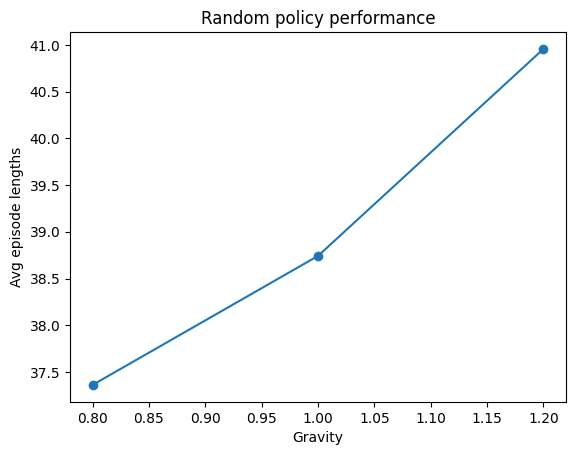

In [16]:
# TODO:
# - Test random policy under gravity × {0.8, 1.0, 1.2}
# - Store average episode length
# - Plot results
avg_epi_lens = []
gravities = [0.8,1.0,1.2]
for g in [0.8,1.0,1.2]:
    env=FlappyEnv(g)
    print(f"=====  Gravity : {g}  =====")
    avg_len = run_random_policy(env)
    avg_epi_lens.append(avg_len)
plt.plot(gravities,avg_epi_lens,marker='o')
plt.xlabel('Gravity')
plt.ylabel('Avg episode lengths')
plt.title('Random policy performance')
plt.show()

## Submission Checklist
- All TODOs implemented
- No RL training code
- Environment deterministic
- Random policy runs without crashing
- Stress test plot included